## Downloads and Imports

In [ ]:
!pip3 install matplotlib plotly contractions nltk scipy tqdm scikit-learn spacy gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions #fixes contractions such as `you're` to you `are`, to clean data
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px

import json
from nltk.tokenize import word_tokenize
from collections import Counter
from tqdm import tqdm
from scipy.sparse import lil_matrix, csr_matrix, save_npz, load_npz
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import TruncatedSVD
from typing import List, Optional, Dict, Tuple, Set

from scipy.spatial.distance import cosine
from scipy.stats import spearmanr, pearsonr

import time



from gensim.models import KeyedVectors
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_distances

# import spacy
# !python -m spacy download en_core_web_sm

In [ ]:
# nlp=spacy.load("en_core_web_sm")

nltk.download('stopwords')
nltk.download('punkt')

stopwords=set(stopwords.words('english'))
nltk.download('punkt_tab')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
!mkdir data
!ls

cooc_outputs.zip  data	sample_data


In [ ]:
!wget -O ./data/english_corpus.tar.gz "https://downloads.wortschatz-leipzig.de/corpora/eng_news_2024_300K.tar.gz"


--2025-06-16 12:41:13--  https://downloads.wortschatz-leipzig.de/corpora/eng_news_2024_300K.tar.gz
Resolving downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)... 139.18.2.68
Connecting to downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)|139.18.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87595861 (84M) [application/x-gzip]
Saving to: ‘./data/english_corpus.tar.gz’

./data/english_corp 100%[===================>]  83.54M  24.2MB/s    in 4.4s    

2025-06-16 12:41:18 (19.2 MB/s) - ‘./data/english_corpus.tar.gz’ saved [87595861/87595861]



In [ ]:
!tar -xzvf ./data/english_corpus.tar.gz -C ./data

eng_news_2024_300K/
eng_news_2024_300K/eng_news_2024_300K-co_n.txt
eng_news_2024_300K/eng_news_2024_300K-co_s.txt
eng_news_2024_300K/eng_news_2024_300K-inv_so.txt
eng_news_2024_300K/eng_news_2024_300K-sentences.txt
eng_news_2024_300K/eng_news_2024_300K-sources.txt
eng_news_2024_300K/eng_news_2024_300K-meta.txt
eng_news_2024_300K/eng_news_2024_300K-inv_w.txt
eng_news_2024_300K/eng_news_2024_300K-words.txt
eng_news_2024_300K/eng_news_2024_300K-import.sql


## Loading the data

In [ ]:
def get_sentences_from_file(file_path):
    """
    Reads the sentences from a Leipzig Corpora file and returns them as a list.

    The file is expected to be in the following format:
        idx\t sentence
    If a line does not contain a tab, it is added to the list unchanged.

    Returns:
        list: A list of sentences from the file.
    """
    sentences=[]
    with open(file_path, encoding='utf-8') as f:
        for i, line in enumerate(f):
            line = line.strip()  # remove \n and any surrounding whitespace
            parts = line.split('\t', 1)  # only split at the first tab
            if len(parts) == 2:
                idx, sentence = parts
                sentences.append(sentence)
            else:
                sentences.append(line)
    return sentences


file_path="./data/eng_news_2024_300K/eng_news_2024_300K-sentences.txt"
dir_path=os.path.dirname(file_path)
os.makedirs(dir_path,exist_ok=True)
raw_sentences=get_sentences_from_file(file_path)
print("the length of the file is",len(raw_sentences))
print(raw_sentences[:2])

the length of the file is 300000
['$1,000 invested in Tesla 14 years ago is now…', '$100 billion for the fourth straight year, reinsurers reported strong results for 2023 while cedents bore losses within higher retentions.']


## Preprocessing, tokenization & vocab building

In [ ]:
def preprocess_tokenize_sentences(sentences: List[str]):
    """
      Preprocesses a list of sentences by lowercasing, removing URLs,
      removing punctuation, tokenizing, and lemmatizing them.
      Returns a list of lists of strings, where each sublist contains the words
      of the corresponding input sentence.
    """
    processed = []
    for sentence in tqdm(sentences):
        sentence = sentence.lower()
        sentence = re.sub(r"http\S+|www\S+|https\S+", '', sentence) #remove urls
        sentence = re.sub(r'[^a-z\s]', '', sentence) #remove digits/punctuations

        words = word_tokenize(sentence) #tokenize using the nlp tokenizer
        words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords and len(word) > 1] #apply lematization
        if words:
            processed.append(words)
    return processed

In [ ]:
def plot_frequency_distribution(word_counts,bins: int = 100) -> None:
        """
        Plot histogram of word frequencies.

        Args:
            bins (int): Number of bins in the histogram.
        """
        counts = list(word_counts.values())
        plt.hist(counts, bins=bins, log=True)
        plt.xlabel("Word Count")
        plt.ylabel("Frequency")
        plt.title("Word Frequency Count")
        plt.show()


In [ ]:
tokenized_sentences = preprocess_tokenize_sentences(raw_sentences) #fetch the tokenized sentences
word_counts = Counter(word for sent in tokenized_sentences for word in sent) #build frequency counts

100%|██████████| 300000/300000 [01:18<00:00, 3842.27it/s]


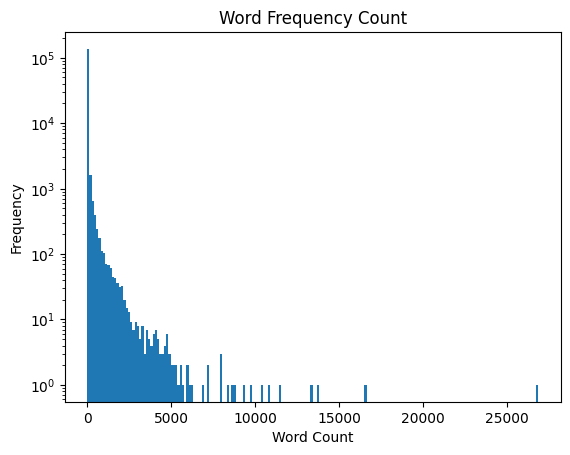

Total unique words: 139567
Words with freq < 4: 102869
Words with freq ≥ 4: 36698
Words with freq < 5: 107790
Words with freq ≥ 5: 31777
Words with freq < 6: 111296
Words with freq ≥ 6: 28271
Words with freq < 7: 113969
Words with freq ≥ 7: 25598
Words with freq ≥ 10: 20541


In [ ]:
plot_frequency_distribution(word_counts,bins=200)
all_counts = np.array(list(word_counts.values()))
print("Total unique words:", len(all_counts))
print("Words with freq < 4:", np.sum(all_counts < 4))
print("Words with freq ≥ 4:", np.sum(all_counts >= 4))
print("Words with freq < 5:", np.sum(all_counts < 5))
print("Words with freq ≥ 5:", np.sum(all_counts >= 5))
print("Words with freq < 6:", np.sum(all_counts < 6))
print("Words with freq ≥ 6:", np.sum(all_counts >= 6))
print("Words with freq < 7:", np.sum(all_counts < 7))
print("Words with freq ≥ 7:", np.sum(all_counts >= 7))
print("Words with freq ≥ 10:", np.sum(all_counts >= 10))

- core vocabulary is small
- only 20k to 30k words appear to be statistically meaningful
- reducing to around 30k would be apt
- 5

In [ ]:
min_count=5 #filter out
vocab = {word for word, count in word_counts.items() if count >= min_count}
word2idx = {word: idx for idx, word in enumerate(sorted(vocab))}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")

Vocab size: 31777


## building co-occurrence matrix

In [ ]:
def build_cooc_matrix(window_size,tokenized_sentences):
  """
    Build a sparse co-occurrence matrix given a window size and list of sentences
    tokenized into individual words. The co-occurrence matrix is a square matrix
    with shape equal to the vocabulary size, where the entry at row i and column j
    is the number of times word i and word j appear in the same window of the text.

    :param int window_size: The window size to use for computing co-occurrences
    :param list[list[str]] tokenized_sentences: A list of sentences, where each
      sentence is a list of words
    :return: A sparse co-occurrence matrix
    :rtype: scipy.sparse.csr_matrix
  """
  window_size = window_size
  cooc_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float32)

  for sentence in tqdm(tokenized_sentences):
      sentence = [w for w in sentence if w in word2idx]   #ensure words exist in vocab *& word2idx
      for i, center_word in enumerate(sentence):
          center_idx = word2idx[center_word]
          start = max(0, i - window_size)
          end = min(len(sentence), i + window_size + 1)
          for j in range(start, end):
              if i == j:
                  continue #dont incremet count if same words
              context_word = sentence[j]
              context_idx = word2idx[context_word]
              cooc_matrix[center_idx, context_idx] += 1.0

  cooc_matrix = cooc_matrix.tocsr() #save as csr matrix
  return cooc_matrix


- Use lil_matrix instead of numpy:
  - only stores non-zero values, so sparse
  - efficient for adding counts (incrementing)
  - faster for row based operations
  - converts to csr_matrix -> faste, sprasers and more memory efficient

> How do i determine an apt window size?

mean: 11.053297148439192
median: 11.0
min: 1
max: 35
std dev: 5.191209866276427
25th percentile: 7.0
75th percentile: 15.0


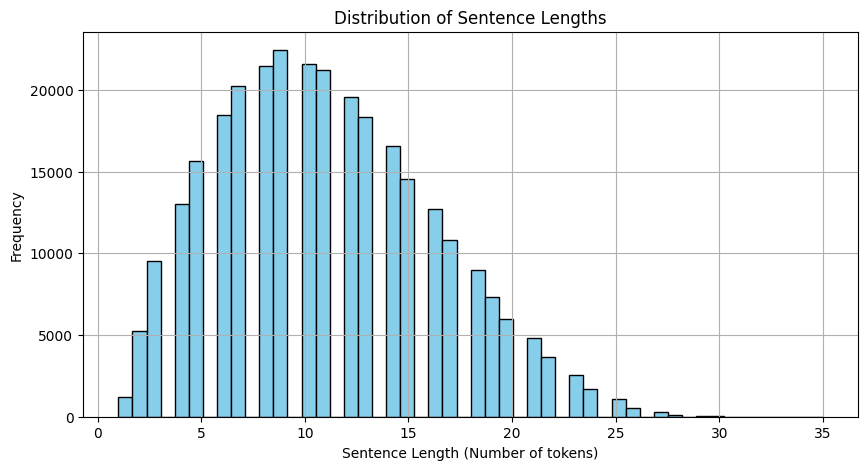

In [ ]:
def sentence_metrics(sentences):
        """
            Calculate and display various statistical metrics and histogram for a list of sentences.

            Parameters:
            sentences (list of str): A list of sentences for which metrics are to be calculated.

            The function computes and prints the mean, median, minimum, maximum, standard deviation,
            25th percentile, and 75th percentile of the sentence lengths. It also plots a histogram
            showing the distribution of sentence lengths.

            The histogram is displayed in a new figure with a title, labeled axes, and grid.
        """
        sentence_lengths = [len(sentence) for sentence in sentences]
        print("mean:", np.mean(sentence_lengths))
        print("median:", np.median(sentence_lengths))
        print("min:", np.min(sentence_lengths))
        print("max:", np.max(sentence_lengths))
        print("std dev:", np.std(sentence_lengths))
        print("25th percentile:", np.percentile(sentence_lengths, 25))
        print("75th percentile:", np.percentile(sentence_lengths, 75))

        plt.figure(figsize=(10, 5))
        plt.hist(sentence_lengths, bins=50, color='skyblue', edgecolor='black')
        plt.title("Distribution of Sentence Lengths")
        plt.xlabel('Sentence Length (Number of tokens)')
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

sentence_metrics(tokenized_sentences)

- right skewed
  - mean > median
- Most of the sentences have 8-10 tokens each
- Based on the graph, try [5,8,10,12,18]
  - 18 since the max is 35

In [ ]:
cooc_5=build_cooc_matrix(window_size=5,tokenized_sentences=tokenized_sentences)
cooc_8=build_cooc_matrix(window_size=8,tokenized_sentences=tokenized_sentences)
cooc_10=build_cooc_matrix(window_size=10,tokenized_sentences=tokenized_sentences)
cooc_12=build_cooc_matrix(window_size=12,tokenized_sentences=tokenized_sentences)
cooc_18=build_cooc_matrix(window_size=18,tokenized_sentences=tokenized_sentences)

100%|██████████| 299941/299941 [03:30<00:00, 1424.31it/s]


## Dimensionality Reduction

### TSVD

In [ ]:
def tsvd_cooc(thresholds,cooc_matrix, cooc_matrix_name, max_components=500, path="./cooc_outputs/tsvd_outputs"):
    
    """
    Applies Truncated SVD to a co-occurrence matrix for various thresholds of explained variance,
    saves the resulting matrices, and plots the cumulative explained variance.

    Args:
    - matrix: The input co-occurrence matrix (sparse matrix).
    - matrix_name: Name of the matrix (e.g., "cooc_2").
    - thresholds: List of thresholds (e.g., [0.85, 0.9, 0.95]) for explained variance.
    - max_components: Maximum number of components for SVD (default 500).
    - path: Directory to save the transformed matrices.
    """

    if not os.path.exists(path):
        os.makedirs(path)

    tsvd = TruncatedSVD(n_components=max_components,n_iter=10)
    start_fit = time.time()
    cooc_tsvd = tsvd.fit_transform(cooc_matrix)
    fit_time_full = time.time() - start_fit

    explained = np.cumsum(tsvd.explained_variance_ratio_)


    plt.plot(explained)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Choosing n_components')
    plt.grid(True)
    plt.show()

    orig_bytes = cooc_matrix.data.nbytes + cooc_matrix.indptr.nbytes + cooc_matrix.indices.nbytes

    for threshold in tqdm(thresholds):
        n_comp_optimal = np.argmax(explained >= threshold) + 1
        print(f"\nThreshold: {threshold} -> Optimal n_components: {n_comp_optimal}")

        tsvd_optimal = TruncatedSVD(n_components=n_comp_optimal,n_iter=10)
        start_fit = time.time()
        reduced_matrix = tsvd_optimal.fit_transform(cooc_matrix)
        fit_time = time.time() - start_fit

        sample_size = min(300, cooc_matrix.shape[0])
        sample_indices = np.random.choice(cooc_matrix.shape[0], size=sample_size, replace=False)
        col_indices = np.random.choice(cooc_matrix.shape[1], size=300, replace=False)

        matrix_sample = cooc_matrix[sample_indices][:, col_indices].toarray()
        reduced_sample = tsvd_optimal.transform(cooc_matrix[sample_indices])
        approx_sample_full = tsvd_optimal.inverse_transform(reduced_sample)
        approx_sample = approx_sample_full[:, col_indices]
        reconstruction_error = np.linalg.norm(matrix_sample - approx_sample, ord='fro') #reconstruction error
       
        comp_bytes = reduced_matrix.nbytes
        compression_ratio = orig_bytes / comp_bytes #compression calc
        save_path = os.path.join(path, f"{cooc_matrix_name}_tsvd_{int(threshold * 100)}.npy")
        np.save(save_path, reduced_matrix)
        print(f"Saved matrix: {save_path}")


        print(f"Fit Time: {fit_time:.2f}s | Memory Used: {comp_bytes / (1024**2):.2f}MB")
        print(f"Reconstruction Error: {reconstruction_error}")
        print(f"Compression Ratio: {compression_ratio:.2f}")




scipy.sparse._csr.csr_matrix

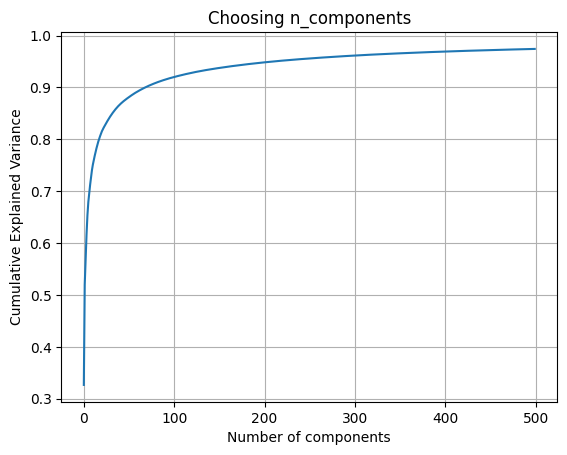

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

threshold: 0.85 -> Optimal components: 33


threshold:  33%|███▎      | 1/3 [00:06<00:13,  6.79s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_5_tsvd_85.npy
Fit Time: 6.75s | Memory Used: 4.00MB
Reconstruction Error: 50.453399658203125
Compression Ratio: 21.42
threshold: 0.9 -> Optimal components: 69


threshold:  67%|██████▋   | 2/3 [00:19<00:10, 10.30s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_5_tsvd_90.npy
Fit Time: 12.68s | Memory Used: 8.36MB
Reconstruction Error: 75.97636413574219
Compression Ratio: 10.24
threshold: 0.95 -> Optimal components: 211


threshold: 100%|██████████| 3/3 [01:02<00:00, 20.82s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_5_tsvd_95.npy
Fit Time: 42.76s | Memory Used: 25.58MB
Reconstruction Error: 39.27756881713867
Compression Ratio: 3.35


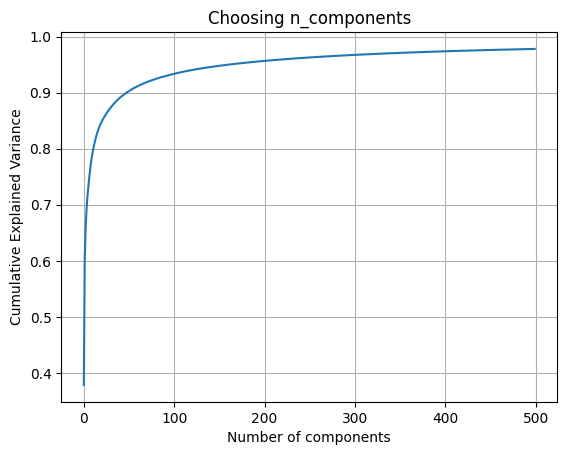

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

threshold: 0.85 -> Optimal components: 22


threshold:  33%|███▎      | 1/3 [00:05<00:11,  5.89s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_8_tsvd_85.npy
Fit Time: 5.85s | Memory Used: 2.67MB
Reconstruction Error: 71.4731674194336
Compression Ratio: 40.19
threshold: 0.9 -> Optimal components: 49


threshold:  67%|██████▋   | 2/3 [00:15<00:07,  7.80s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_8_tsvd_90.npy
Fit Time: 9.09s | Memory Used: 5.94MB
Reconstruction Error: 97.32177734375
Compression Ratio: 18.04
threshold: 0.95 -> Optimal components: 162


threshold: 100%|██████████| 3/3 [00:53<00:00, 17.91s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_8_tsvd_95.npy
Fit Time: 38.58s | Memory Used: 19.64MB
Reconstruction Error: 78.9987564086914
Compression Ratio: 5.46


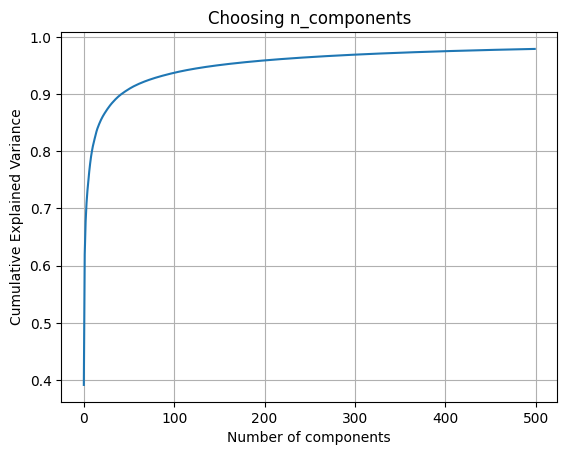

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

threshold: 0.85 -> Optimal components: 19


threshold:  33%|███▎      | 1/3 [00:06<00:13,  6.80s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_10_tsvd_85.npy
Fit Time: 6.74s | Memory Used: 2.30MB
Reconstruction Error: 129.30604553222656
Compression Ratio: 50.09
threshold: 0.9 -> Optimal components: 43


threshold:  67%|██████▋   | 2/3 [00:17<00:09,  9.03s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_10_tsvd_90.npy
Fit Time: 10.52s | Memory Used: 5.21MB
Reconstruction Error: 125.6397705078125
Compression Ratio: 22.13
threshold: 0.95 -> Optimal components: 148


threshold: 100%|██████████| 3/3 [00:58<00:00, 19.66s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_10_tsvd_95.npy
Fit Time: 41.48s | Memory Used: 17.94MB
Reconstruction Error: 74.5481948852539
Compression Ratio: 6.43


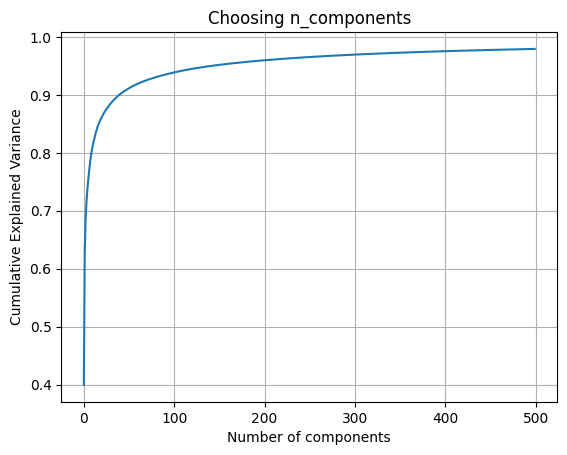

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

threshold: 0.85 -> Optimal components: 18


threshold:  33%|███▎      | 1/3 [00:06<00:13,  6.70s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_12_tsvd_85.npy
Fit Time: 6.67s | Memory Used: 2.18MB
Reconstruction Error: 137.9127655029297
Compression Ratio: 55.17
threshold: 0.9 -> Optimal components: 41


threshold:  67%|██████▋   | 2/3 [00:18<00:09,  9.50s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_12_tsvd_90.npy
Fit Time: 11.41s | Memory Used: 4.97MB
Reconstruction Error: 59.23915481567383
Compression Ratio: 24.22
threshold: 0.95 -> Optimal components: 143


threshold: 100%|██████████| 3/3 [01:05<00:00, 21.71s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_12_tsvd_95.npy
Fit Time: 46.86s | Memory Used: 17.33MB
Reconstruction Error: 73.86819458007812
Compression Ratio: 6.94


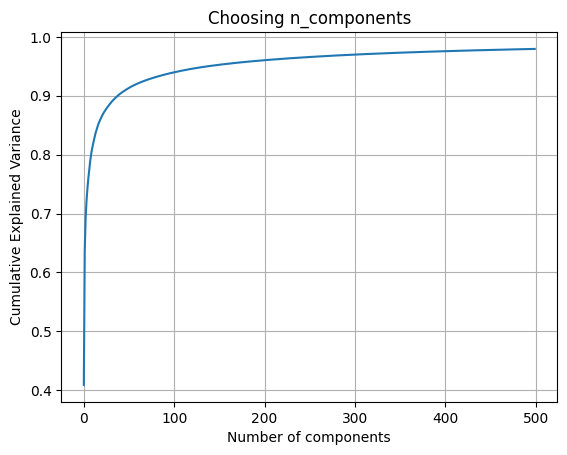

threshold:   0%|          | 0/3 [00:00<?, ?it/s]

threshold: 0.85 -> Optimal components: 17


threshold:  33%|███▎      | 1/3 [00:07<00:15,  7.87s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_18_tsvd_85.npy
Fit Time: 7.84s | Memory Used: 2.06MB
Reconstruction Error: 80.87670135498047
Compression Ratio: 60.94
threshold: 0.9 -> Optimal components: 39


threshold:  67%|██████▋   | 2/3 [00:18<00:09,  9.21s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_18_tsvd_90.npy
Fit Time: 10.11s | Memory Used: 4.73MB
Reconstruction Error: 108.90860748291016
Compression Ratio: 26.56
threshold: 0.95 -> Optimal components: 139


threshold: 100%|██████████| 3/3 [00:59<00:00, 19.87s/it]

Saved matrix: ./cooc_outputs/tsvd_outputs/cooc_18_tsvd_95.npy
Fit Time: 41.46s | Memory Used: 16.85MB
Reconstruction Error: 66.57526397705078
Compression Ratio: 7.45


In [ ]:
thresholds=[0.85,0.90,0.95]
tsvd_cooc(thresholds=thresholds,cooc_matrix=cooc_5,cooc_matrix_name="cooc_5")
tsvd_cooc(thresholds=thresholds,cooc_matrix=cooc_8,cooc_matrix_name="cooc_8")
tsvd_cooc(thresholds=thresholds,cooc_matrix=cooc_10,cooc_matrix_name="cooc_10")
tsvd_cooc(thresholds=thresholds,cooc_matrix=cooc_12,cooc_matrix_name="cooc_12")
tsvd_cooc(thresholds=thresholds,cooc_matrix=cooc_18,cooc_matrix_name="cooc_18")

## Evaluation

In [ ]:
!wget https://fh295.github.io/SimLex-999.zip
!unzip SimLex-999.zip

--2025-06-16 12:44:32--  https://fh295.github.io/SimLex-999.zip
Resolving fh295.github.io (fh295.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fh295.github.io (fh295.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16805 (16K) [application/x-zip-compressed]
Saving to: ‘SimLex-999.zip’

SimLex-999.zip      100%[===================>]  16.41K  --.-KB/s    in 0.001s  

2025-06-16 12:44:32 (11.2 MB/s) - ‘SimLex-999.zip’ saved [16805/16805]

Archive:  SimLex-999.zip
   creating: SimLex-999/
  inflating: SimLex-999/README.txt   
  inflating: SimLex-999/SimLex-999.txt  


In [ ]:
!wget https://gabrilovich.com/resources/data/wordsim353/wordsim353.zip
!unzip wordsim353.zip

--2025-06-16 12:44:34--  https://gabrilovich.com/resources/data/wordsim353/wordsim353.zip
Resolving gabrilovich.com (gabrilovich.com)... 173.236.137.139
Connecting to gabrilovich.com (gabrilovich.com)|173.236.137.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23257 (23K) [application/zip]
Saving to: ‘wordsim353.zip’

wordsim353.zip      100%[===================>]  22.71K  --.-KB/s    in 0.03s   

2025-06-16 12:44:34 (650 KB/s) - ‘wordsim353.zip’ saved [23257/23257]

Archive:  wordsim353.zip
  inflating: combined.csv            
  inflating: set1.csv                
  inflating: set2.csv                
  inflating: combined.tab            
  inflating: set1.tab                
  inflating: set2.tab                
  inflating: instructions.txt        


In [ ]:
wordsim_df = pd.read_csv("combined.csv")
wordsim_df.columns = ['Word1', 'Word2', 'Human_Score']

In [ ]:
simlex_df = pd.read_csv("SimLex-999/SimLex-999.txt", sep="\t")
simlex_df = simlex_df[['word1', 'word2', 'SimLex999']]
simlex_df.columns = ['Word1', 'Word2', 'Human_Score']

In [ ]:
def filter_dataset(df, word2idx):
    """
    Filter wordsim/simlex and return only the rows where both words can be found in word2idx
    The returned list contains tuples of (word1, word2, score)
    """
    filtered = []
    for _, row in df.iterrows():
        w1, w2 = row['Word1'].lower(), row['Word2'].lower()
        if w1 in word2idx and w2 in word2idx:
            filtered.append((w1, w2, row['Human_Score']))
    return filtered

In [ ]:
wordsim_data = filter_dataset(wordsim_df, word2idx) #lists [word1,word2,score]
simlex_data = filter_dataset(simlex_df, word2idx) #lists

print(f"Filtered WordSim353: {len(wordsim_data)} pairs")
print(f"Filtered SimLex-999: {len(simlex_data)} pairs")

Filtered WordSim353: 335 pairs
Filtered SimLex-999: 981 pairs


In [ ]:
def evaluate_similarity(data, embeddings, word2idx):
    """
    Evaluate a set of word embeddings on a word similarity task.
    data : list of (str, str, float)
        List of word pairs and associated human-annotated similarity scores.
    embeddings : array_like
        Array of word embeddings.
    word2idx : dict
        Mapping from words to indices in the embeddings array.

    Returns
    spearman_corr : float
        Spearman rank correlation between predicted and gold similarity scores.
    pearson_corr : float
        Pearson correlation between predicted and gold similarity scores.
    """
    predicted = []
    gold = []

    for w1, w2, score in data:
        v1 = embeddings[word2idx[w1]]
        v2 = embeddings[word2idx[w2]]
        sim = 1 - cosine(v1, v2)
        predicted.append(sim)
        gold.append(score)

    spearman_corr = spearmanr(gold, predicted).correlation
    pearson_corr = pearsonr(gold, predicted)[0]

    return spearman_corr, pearson_corr

In [ ]:
tsvd_path = "./cooc_outputs/tsvd_outputs"

for filename in sorted(os.listdir(tsvd_path)):
    if filename.endswith(".npy"):
        filepath = os.path.join(tsvd_path, filename)
        embedding_matrix = np.load(filepath)

        spearman_ws, pearson_ws = evaluate_similarity(wordsim_data, embedding_matrix, word2idx)
        spearman_sl, pearson_sl = evaluate_similarity(simlex_data, embedding_matrix, word2idx)

        print(f"Results for {filename}:")
        print(f"  WordSim353 - Spearman: {spearman_ws:.4f}, Pearson: {pearson_ws:.4f}")
        print(f"  SimLex999 - Spearman: {spearman_sl:.4f}, Pearson: {pearson_sl:.4f}")
        print("-" * 60)

Results for cooc_10_tsvd_85.npy:
  WordSim353 - Spearman: 0.1752, Pearson: 0.2338
  SimLex999 - Spearman: 0.0310, Pearson: 0.0635
------------------------------------------------------------
Results for cooc_10_tsvd_90.npy:
  WordSim353 - Spearman: 0.2513, Pearson: 0.2886
  SimLex999 - Spearman: 0.0458, Pearson: 0.0670
------------------------------------------------------------
Results for cooc_10_tsvd_95.npy:
  WordSim353 - Spearman: 0.2801, Pearson: 0.3241
  SimLex999 - Spearman: 0.0570, Pearson: 0.0595
------------------------------------------------------------
Results for cooc_12_tsvd_85.npy:
  WordSim353 - Spearman: 0.1783, Pearson: 0.2302
  SimLex999 - Spearman: 0.0331, Pearson: 0.0679
------------------------------------------------------------
Results for cooc_12_tsvd_90.npy:
  WordSim353 - Spearman: 0.2534, Pearson: 0.2840
  SimLex999 - Spearman: 0.0415, Pearson: 0.0671
------------------------------------------------------------
Results for cooc_12_tsvd_95.npy:
  WordSim353

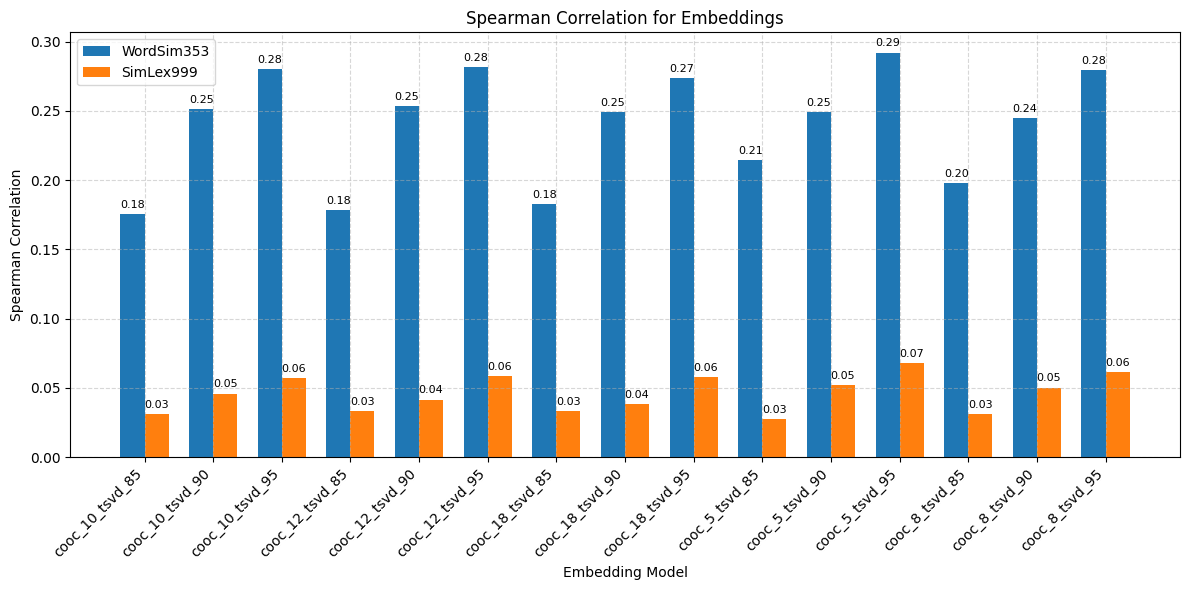

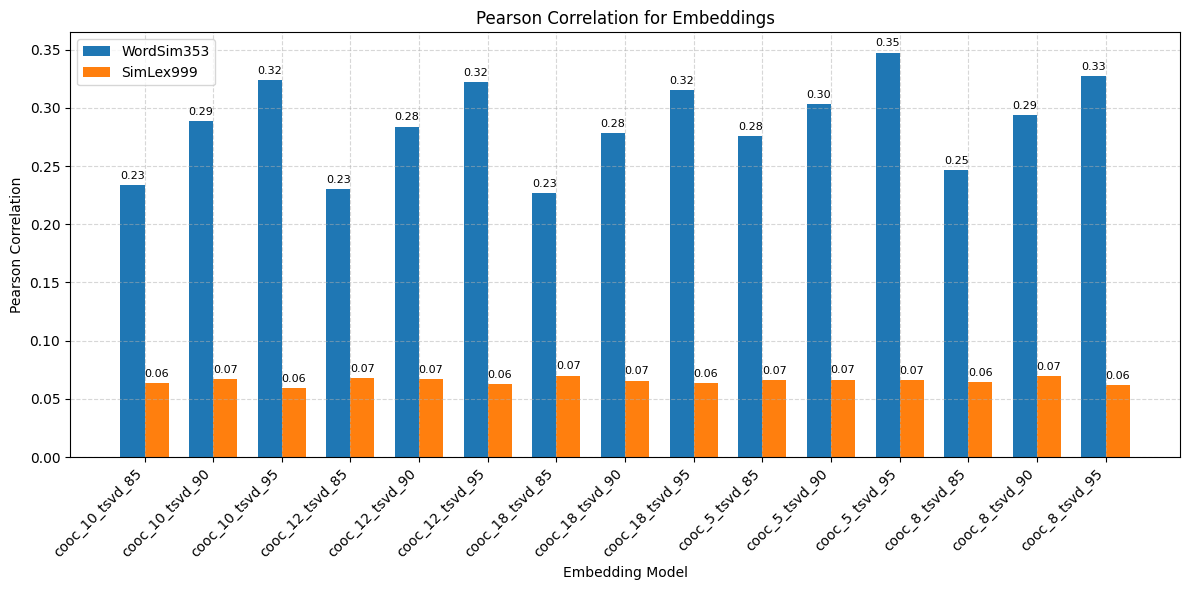

In [ ]:
tsvd_path = "./cooc_outputs/tsvd_outputs"

model_names = []
wordsim_spearman = []
simlex_spearman = []
wordsim_pearson = []
simlex_pearson = []

for filename in sorted(os.listdir(tsvd_path)):
    if filename.endswith(".npy"):
        filepath = os.path.join(tsvd_path, filename)
        embedding_matrix = np.load(filepath)

        spearman_ws, pearson_ws = evaluate_similarity(wordsim_data, embedding_matrix, word2idx)
        spearman_sl, pearson_sl = evaluate_similarity(simlex_data, embedding_matrix, word2idx)

        model_names.append(filename.replace(".npy", ""))
        wordsim_spearman.append(spearman_ws)
        simlex_spearman.append(spearman_sl)
        wordsim_pearson.append(pearson_ws)
        simlex_pearson.append(pearson_sl)


def plot_grouped_bar(scores1, scores2, title, ylabel, labels):
    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, scores1, width, label=labels[0])
    bars2 = ax.bar(x + width/2, scores2, width, label=labels[1])

    ax.set_xlabel('Embedding Model')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

plot_grouped_bar(wordsim_spearman, simlex_spearman,
                 title='Spearman Correlation for Embeddings',
                 ylabel='Spearman Correlation',
                 labels=['WordSim353', 'SimLex999'])

plot_grouped_bar(wordsim_pearson, simlex_pearson,
                 title='Pearson Correlation for Embeddings',
                 ylabel='Pearson Correlation',
                 labels=['WordSim353', 'SimLex999'])

## Co-occurrence matrix evaluations

- loading the best 4 matrics

In [ ]:
cooc_5_tsvd_95=np.load("./cooc_outputs/tsvd_outputs/cooc_5_tsvd_95.npy")
cooc_12_tsvd_90=np.load("./cooc_outputs/tsvd_outputs/cooc_12_tsvd_90.npy")
cooc_10_tsvd_95=np.load("./cooc_outputs/tsvd_outputs/cooc_10_tsvd_95.npy")
cooc_8_tsvd_95=np.load("./cooc_outputs/tsvd_outputs/cooc_8_tsvd_95.npy")

In [ ]:
eval_mats=[cooc_5_tsvd_95,cooc_12_tsvd_90,cooc_10_tsvd_95,cooc_8_tsvd_95]

### semantic clusters

=== Results for cooc_10_tsvd_95.npy ===
  WordSim353 -> Spearman: 0.2801, Pearson: 0.3241
  SimLex999  -> Spearman: 0.0570, Pearson: 0.0595
------------------------------------------------------------


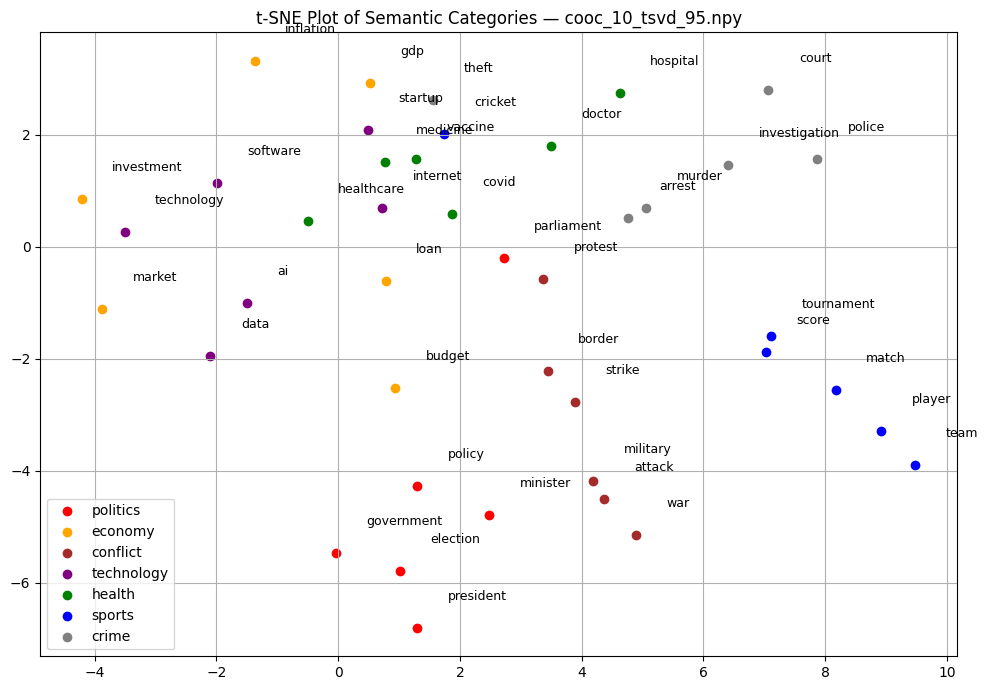

=== Results for cooc_12_tsvd_90.npy ===
  WordSim353 -> Spearman: 0.2534, Pearson: 0.2840
  SimLex999  -> Spearman: 0.0415, Pearson: 0.0671
------------------------------------------------------------


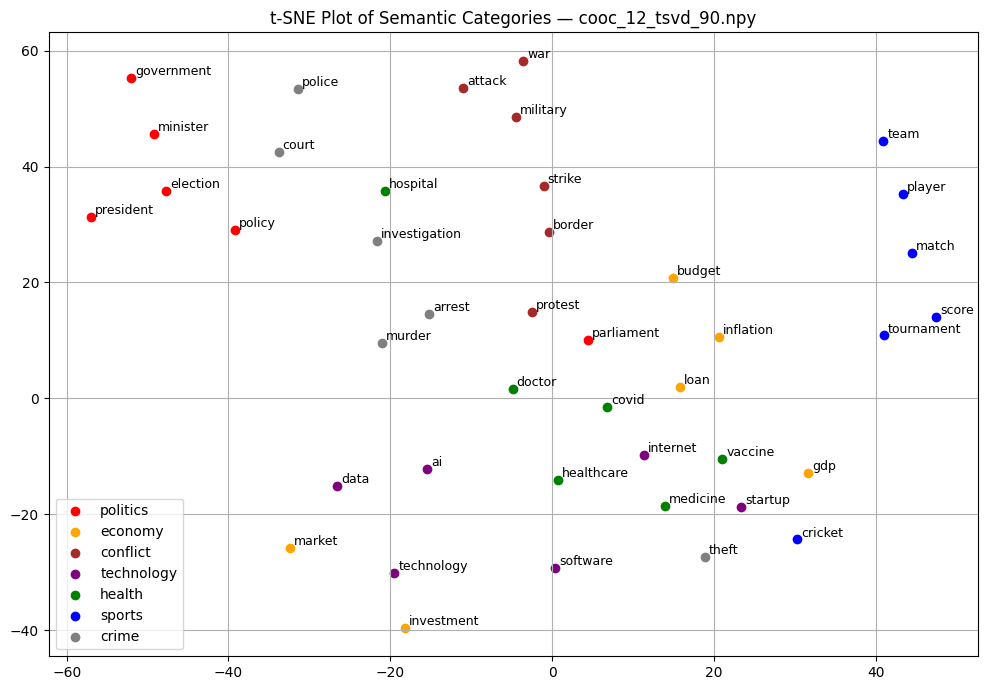

=== Results for cooc_5_tsvd_95.npy ===
  WordSim353 -> Spearman: 0.2921, Pearson: 0.3476
  SimLex999  -> Spearman: 0.0680, Pearson: 0.0662
------------------------------------------------------------


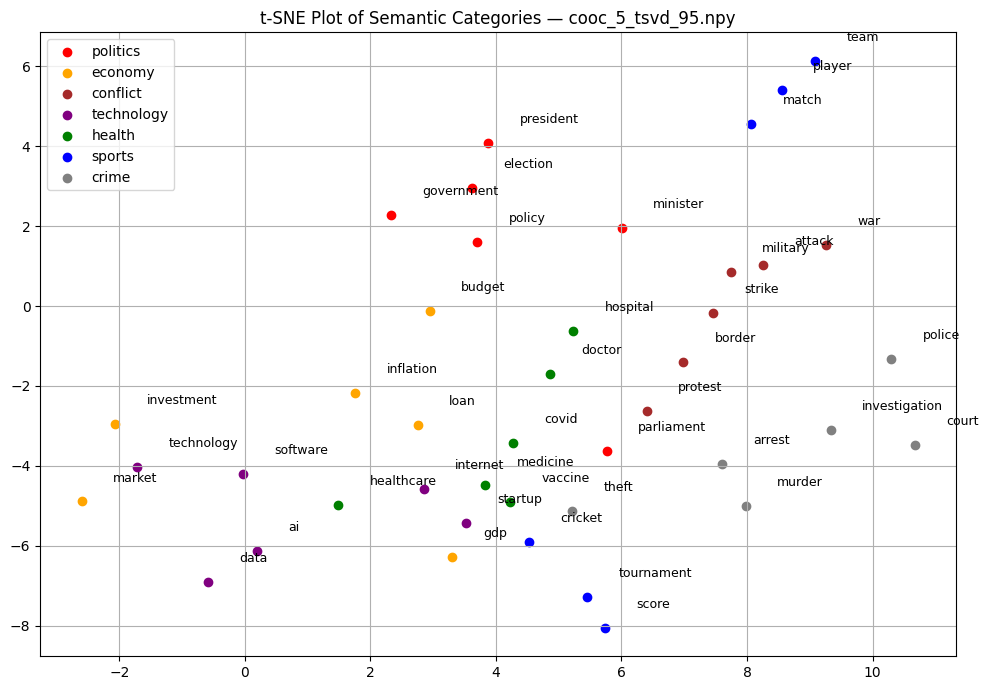

=== Results for cooc_8_tsvd_95.npy ===
  WordSim353 -> Spearman: 0.2796, Pearson: 0.3272
  SimLex999  -> Spearman: 0.0613, Pearson: 0.0619
------------------------------------------------------------


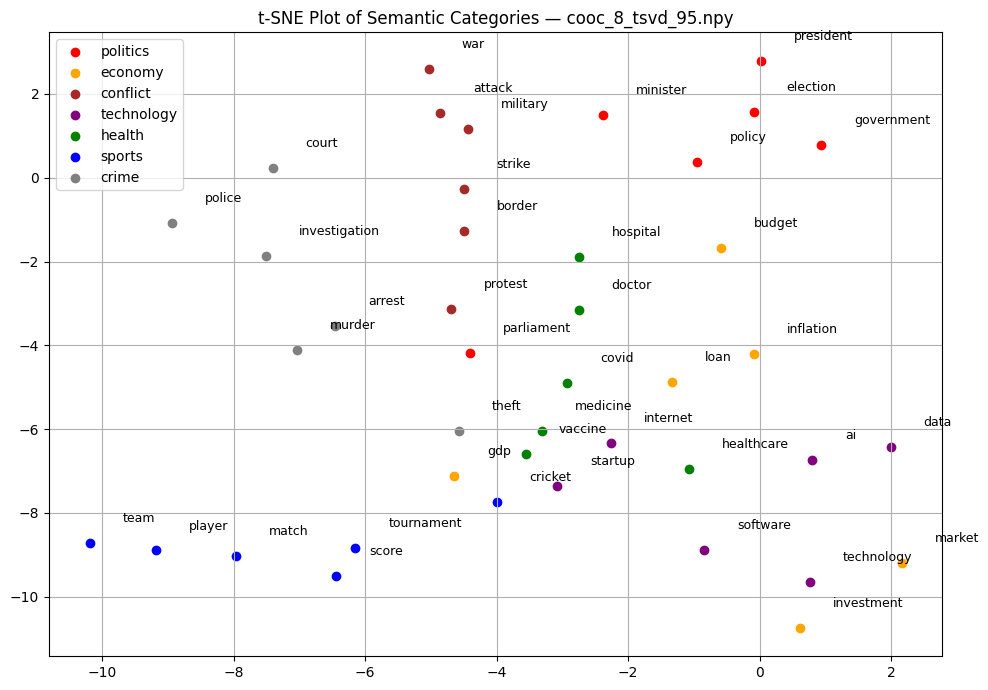

In [ ]:
#mapping topic groups to representative keywords
semantic_categories = {
    "politics": ["government", "election", "policy", "minister", "parliament", "president"],
    "economy": ["market", "inflation", "budget", "gdp", "investment", "loan"],
    "conflict": ["war", "protest", "attack", "military", "border", "strike"],
    "technology": ["technology", "software", "internet", "ai", "data", "startup"],
    "health": ["hospital", "doctor", "vaccine", "covid", "healthcare", "medicine"],
    "sports": ["cricket", "tournament", "player", "match", "score", "team"],
    "crime": ["police", "arrest", "court", "murder", "theft", "investigation"],
}

#assign a unique color to each category (for plotting)
category_colors = {
    "politics": "red",
    "economy": "orange",
    "conflict": "brown",
    "technology": "purple",
    "health": "green",
    "sports": "blue",
    "crime": "gray"
}


embedding_dir = "./cooc_outputs/tsvd_outputs"

#only process these specific embedding files (others will be skipped)
selected_embeddings = [
    "cooc_5_tsvd_95.npy",
    "cooc_12_tsvd_90.npy",
    "cooc_10_tsvd_95.npy",
    "cooc_8_tsvd_95.npy"
]

#go through each file in the directory
for emb_file in sorted(os.listdir(embedding_dir)):
    if not emb_file.endswith(".npy"):
        continue  #skip non-numpy files

    if emb_file not in selected_embeddings:
        continue  #skip files not interested in

    full_path = os.path.join(embedding_dir, emb_file)
    embedding = np.load(full_path)

    #evaluate against spearman wordsim pearson simlex
    spearman_ws, pearson_ws = evaluate_similarity(wordsim_data, embedding, word2idx)
    spearman_sl, pearson_sl = evaluate_similarity(simlex_data, embedding, word2idx)

    print(f"=== Results for {emb_file} ===")
    print(f"  WordSim353 -> Spearman: {spearman_ws:.4f}, Pearson: {pearson_ws:.4f}")
    print(f"  SimLex999  -> Spearman: {spearman_sl:.4f}, Pearson: {pearson_sl:.4f}")
    print("-" * 60)

    #collect words from each semantic category that exist in the vocab
    vocab_words = []
    category_labels = []

    for category, keywords in semantic_categories.items():
        for word in keywords:
            if word in word2idx:
                vocab_words.append(word)
                category_labels.append(category)

    #not enough words to visualize meaningfully?
    if len(vocab_words) < 5:
        print(f"Skipping t-SNE for {emb_file} — too few known words in vocab.")
        continue

    word_indices = [word2idx[word] for word in vocab_words]
    word_vectors = embedding[word_indices]

    #reduce dimensionality with tsne for visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, init="pca", learning_rate="auto")
    reduced_vectors = tsne.fit_transform(word_vectors)

    #plotting the words in 2D space
    plt.figure(figsize=(10, 7))
    for i, (word, category) in enumerate(zip(vocab_words, category_labels)):
        plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1],
                    c=category_colors[category],
                    label=category if category not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.text(reduced_vectors[i, 0] + 0.5, reduced_vectors[i, 1] + 0.5, word, fontsize=9)

    plt.title(f"t-SNE Plot of Semantic Categories — {emb_file}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Nearest Neighbor evaluations

In [ ]:
news_neighs = ["government", "budget", "vaccine", "strike", "internet"]

In [ ]:
def get_top_k_neighbors(word, embeddings, word_to_index, index_to_word, k=10):
    idx = word_to_index[word]
    vec = embeddings[idx].reshape(1, -1)

    #compute cosine similarities
    sims = cosine_similarity(vec, embeddings)[0]

    #het top k (excluding itself)
    top_k_idx = sims.argsort()[::-1][1:k+1]
    return [(index_to_word[i], sims[i]) for i in top_k_idx]

In [ ]:

for mat in eval_mats:
  print(get_top_k_neighbors(news_neighs[0],mat,word2idx,idx2word)) #government

[('authority', 0.8464972), ('policy', 0.82799643), ('ban', 0.82751775), ('funding', 0.8272983), ('union', 0.82528883), ('regulator', 0.8216351), ('regulation', 0.8146555), ('establishment', 0.8102644), ('mandate', 0.80979156), ('agreement', 0.8091486)]
[('mandate', 0.97275776), ('union', 0.9712282), ('citizen', 0.96706754), ('policy', 0.9647993), ('implementation', 0.962292), ('citizenship', 0.9606384), ('servant', 0.9581905), ('nigerian', 0.95505327), ('legislation', 0.95494545), ('reform', 0.95419294)]
[('implementation', 0.9105953), ('union', 0.90706533), ('policy', 0.9036505), ('mandate', 0.89858687), ('citizen', 0.8964202), ('ban', 0.88820195), ('legislation', 0.8874979), ('funding', 0.8861911), ('authority', 0.8840363), ('regulator', 0.8830275)]
[('implementation', 0.8923168), ('policy', 0.8890177), ('union', 0.8865097), ('mandate', 0.8832334), ('authority', 0.8794841), ('citizen', 0.87649846), ('ban', 0.8748473), ('regulator', 0.8728106), ('funding', 0.8724765), ('legislation', 

In [ ]:
for mat in eval_mats:
  print(get_top_k_neighbors(news_neighs[1],mat,word2idx,idx2word))  #budget

[('funding', 0.888267), ('debt', 0.8511283), ('agreed', 0.8377342), ('allocated', 0.83495855), ('plan', 0.82404596), ('grant', 0.82330793), ('salary', 0.8232447), ('scheme', 0.82180977), ('expenditure', 0.8102081), ('taxpayer', 0.8039931)]
[('tax', 0.9616199), ('salary', 0.9540582), ('debt', 0.948323), ('shortfall', 0.94498974), ('pensioner', 0.9409175), ('wage', 0.9381584), ('subsidy', 0.937105), ('funding', 0.9360396), ('implemented', 0.9331742), ('expenditure', 0.93113095)]
[('debt', 0.89671445), ('funding', 0.8934598), ('salary', 0.8811561), ('expenditure', 0.8746196), ('spending', 0.8679148), ('cost', 0.86184776), ('allocated', 0.8596358), ('agreed', 0.8594037), ('taxpayer', 0.8587274), ('plan', 0.85410684)]
[('funding', 0.8994629), ('debt', 0.8888114), ('salary', 0.86348456), ('expenditure', 0.8621859), ('agreed', 0.8547289), ('tax', 0.85331804), ('cost', 0.85206985), ('scheme', 0.8511827), ('spending', 0.8510175), ('plan', 0.8498724)]


In [ ]:
for mat in eval_mats:
  print(get_top_k_neighbors(news_neighs[2],mat,word2idx,idx2word)) #vaccine

[('experiencing', 0.7933563), ('virus', 0.7910775), ('disease', 0.7850057), ('therapy', 0.7715073), ('benefit', 0.7706441), ('vaccination', 0.7702428), ('issue', 0.76823866), ('prevention', 0.7661933), ('cancer', 0.7638904), ('physical', 0.7620896)]
[('hiv', 0.95569354), ('addiction', 0.954382), ('experiencing', 0.9531589), ('disease', 0.9512032), ('kidney', 0.9511676), ('treatment', 0.94739836), ('health', 0.94648564), ('virus', 0.9457952), ('workplace', 0.9457829), ('nh', 0.94534606)]
[('virus', 0.8594306), ('experiencing', 0.847372), ('vaccination', 0.84732354), ('disease', 0.84234285), ('addiction', 0.83593047), ('flu', 0.8272928), ('autism', 0.82572687), ('medication', 0.8213089), ('physical', 0.8195859), ('care', 0.8183532)]
[('virus', 0.8417566), ('vaccination', 0.8401503), ('disease', 0.83023405), ('experiencing', 0.8285344), ('addiction', 0.8199195), ('flu', 0.81158006), ('physical', 0.8086926), ('autism', 0.8068261), ('care', 0.80396307), ('therapy', 0.8026979)]


In [ ]:
for mat in eval_mats:
  print(get_top_k_neighbors(news_neighs[3],mat,word2idx,idx2word)) #strike

[('attack', 0.91332585), ('military', 0.8954412), ('syria', 0.89375746), ('targeted', 0.88550156), ('soldier', 0.87792844), ('fighter', 0.87624156), ('troop', 0.85434854), ('army', 0.848574), ('damascus', 0.8484336), ('hezbollah', 0.84350276)]
[('attack', 0.9782222), ('soldier', 0.9703923), ('troop', 0.9663994), ('fighter', 0.965288), ('territory', 0.96334326), ('ballistic', 0.96287), ('military', 0.95869225), ('syria', 0.956812), ('drone', 0.95640254), ('army', 0.9545976)]
[('attack', 0.94575864), ('military', 0.92541957), ('syria', 0.9247557), ('fighter', 0.92285883), ('soldier', 0.9176887), ('targeted', 0.9166038), ('territory', 0.9132774), ('army', 0.8976361), ('terrorist', 0.89374113), ('rebel', 0.88974625)]
[('attack', 0.93482494), ('syria', 0.923753), ('military', 0.92056495), ('soldier', 0.91541314), ('targeted', 0.90995914), ('fighter', 0.90789884), ('territory', 0.895777), ('army', 0.8891275), ('troop', 0.8821775), ('terrorist', 0.8791658)]


In [ ]:
for mat in eval_mats:
  print(get_top_k_neighbors(news_neighs[4],mat,word2idx,idx2word)) #internet

[('online', 0.8491076), ('customer', 0.8399946), ('access', 0.83249617), ('offer', 0.8295317), ('offering', 0.8257549), ('mobile', 0.8173441), ('using', 0.81462216), ('delivery', 0.8031048), ('use', 0.79951316), ('offered', 0.7994863)]
[('online', 0.9700793), ('us', 0.9591269), ('website', 0.95886445), ('involves', 0.957163), ('using', 0.95641273), ('mobile', 0.95628244), ('cosmetic', 0.95114547), ('traditional', 0.9486661), ('exposure', 0.94839597), ('attention', 0.94778913)]
[('online', 0.90548724), ('mobile', 0.8834691), ('web', 0.87201786), ('using', 0.8714691), ('access', 0.8705537), ('via', 0.870117), ('link', 0.8666417), ('customer', 0.86367023), ('offer', 0.860701), ('phone', 0.85995364)]
[('online', 0.8868046), ('mobile', 0.86826134), ('customer', 0.8567563), ('access', 0.85593694), ('using', 0.8527303), ('offer', 0.8511661), ('via', 0.85040534), ('link', 0.840712), ('offering', 0.84054637), ('use', 0.8398027)]


### cosine similarity evaluation

In [ ]:
def get_cosine_similarity(word1, word2, word2idx, embedding_matrix):
    idx1 = word2idx[word1]
    idx2 = word2idx[word2]

    vec1 = embedding_matrix[idx1].reshape(1, -1)
    vec2 = embedding_matrix[idx2].reshape(1, -1)

    return cosine_similarity(vec1, vec2)[0][0]

In [ ]:
related_pairs = [
    ("king", "queen"),
    ("doctor", "nurse"),
    ("apple", "banana"),
    ("car", "engine"),
    ("sun", "light"),
    ("teacher", "student"),
]

unrelated_pairs = [
    ("ratio", "king"),
    ("river", "computer"),
    ("doctor","tigress"),
    ("banana", "gun"),
    ("banana","oil"),
    ("shoe", "sky"),
    ("chair", "language"),
    ("dog", "keyboard"),
]

synonym_pairs = [
    ("fast", "quick"),
    ("big", "large"),
    ("happy", "joyful"),
    ("smart", "intelligent"),
    ("cold", "chilly"),
    ("angry", "mad"),
]

antonym_pairs = [
    ("hot", "cold"),
    ("happy", "sad"),
    ("big", "small"),
    ("fast", "slow"),
    ("love", "hate"),
    ("light", "dark"),
]







In [ ]:
mat=eval_mats[0]

for category_name, pairs in {
    "Related": related_pairs,
    "Unrelated": unrelated_pairs,
    "Synonyms": synonym_pairs,
    "Antonyms": antonym_pairs,
}.items():
    print(f"\n== {category_name.upper()} ==")
    for w1, w2 in pairs:
        try:
            score = get_cosine_similarity(w1, w2, word2idx, mat)
            print(f"{w1:10s} - {w2:10s}: {score:.4f}")
        except KeyError:
            print(f"{w1} or {w2} not in vocab.")


== RELATED ==
king       - queen     : 0.9156
doctor     - nurse     : 0.8605
apple      - banana    : 0.4243
car        - engine    : 0.6819
sun        - light     : 0.8483
teacher    - student   : 0.8991

== UNRELATED ==
ratio      - king      : 0.0183
river      - computer  : 0.4772
doctor     - tigress   : 0.0159
banana     - gun       : 0.5943
banana     - oil       : 0.3898
shoe       - sky       : 0.5601
chair      - language  : 0.6005
dog        - keyboard  : 0.5147

== SYNONYMS ==
fast       - quick     : 0.1165
big        - large     : 0.7014
happy      - joyful    : 0.7202
smart      - intelligent: 0.6188
cold       - chilly    : 0.7203
angry      - mad       : 0.7338

== ANTONYMS ==
hot        - cold      : 0.8843
happy      - sad       : 0.8330
big        - small     : 0.8060
fast       - slow      : 0.7949
love       - hate      : 0.8086
light      - dark      : 0.8653


In [ ]:
related_pairs_news = [
    ("government", "policy"),
    ("vaccine", "immunity"),
    ("inflation", "prices"),
    ("protest", "strike"),
    ("election", "vote"),
    ("budget", "deficit"),
]
unrelated_pairs_news = [
    ("democracy", "banana"),
    ("gdp", "guitar"),
    ("pandemic", "truck"),
    ("minister", "moon"),
    ("stock", "tree"),
    ("soldier", "piano"),
    ("hospital", "keyboard"),
    ("court", "shampoo"),
]
synonym_pairs_news = [
    ("pandemic", "epidemic"),
    ("protest", "demonstration"),
    ("policy", "regulation"),
    ("military", "army"),
    ("virus", "pathogen"),
    ("president", "leader"),
]

antonym_pairs_news = [
    ("peace", "war"),
    ("inflation", "deflation"),
    ("liberal", "conservative"),
    ("public", "private"),
    ("growth", "recession"),
    ("freedom", "censorship"),
]



mat=eval_mats[1]

for category_name, pairs in {
    "Related": related_pairs_news,
    "Unrelated": unrelated_pairs_news,
    "Synonyms": synonym_pairs_news,
    "Antonyms": antonym_pairs_news,
}.items():
    print(f"\n== {category_name.upper()} ==")
    for w1, w2 in pairs:
        try:
            score = get_cosine_similarity(w1, w2, word2idx, mat)
            print(f"{w1:10s} - {w2:10s}: {score:.4f}")
        except KeyError:
            print(f"{w1} or {w2} not in vocab.")



== RELATED ==
government - policy    : 0.9648
vaccine    - immunity  : 0.5672
inflation or prices not in vocab.
protest    - strike    : 0.8798
election   - vote      : 0.9648
budget     - deficit   : 0.8539

== UNRELATED ==
democracy  - banana    : 0.7663
gdp        - guitar    : 0.3428
pandemic   - truck     : 0.7536
minister   - moon      : 0.5399
stock      - tree      : 0.1221
soldier    - piano     : 0.5656
hospital   - keyboard  : 0.4172
court      - shampoo   : 0.2911

== SYNONYMS ==
pandemic   - epidemic  : 0.8018
protest    - demonstration: 0.9128
policy     - regulation: 0.9376
military   - army      : 0.9634
virus or pathogen not in vocab.
president  - leader    : 0.7844

== ANTONYMS ==
peace      - war       : 0.8646
inflation  - deflation : 0.7122
liberal    - conservative: 0.9644
public     - private   : 0.9177
growth     - recession : 0.8946
freedom    - censorship: 0.7892


<ipython-input-57-2593419554>:26: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method="average")


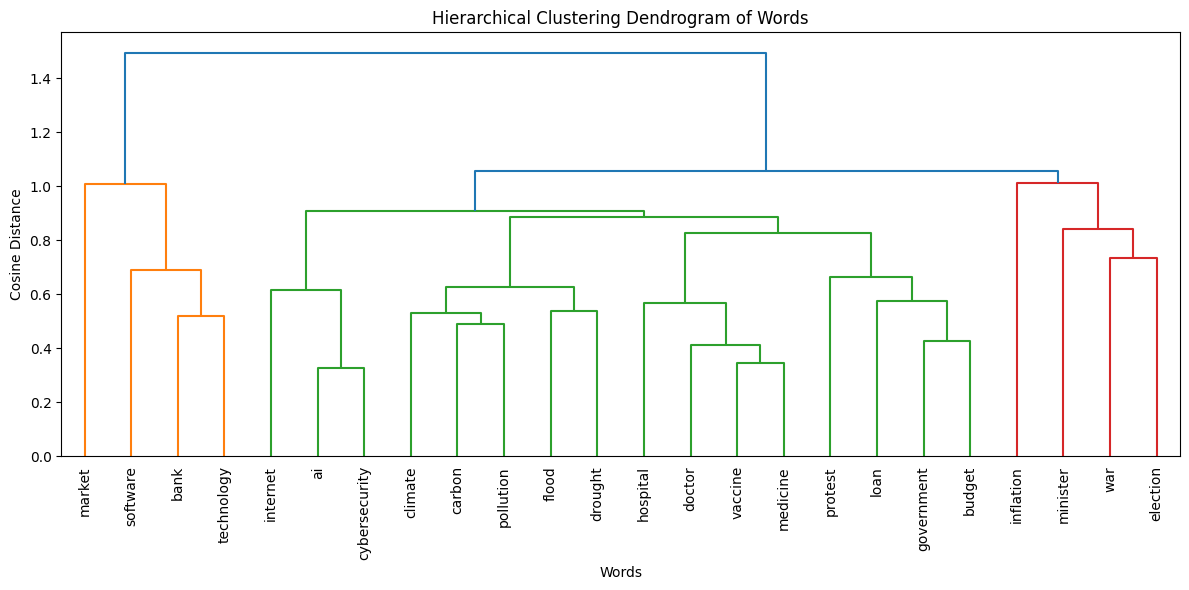

In [ ]:
# words = ["cat", "dog", "lion", "tiger", "elephant", "car", "bus", "truck", "hammer", "screwdriver", "doctor", "nurse", "teacher"]

news_words = [
    #conflict/politics
    "war", "protest", "election", "government", "minister",

    #economy
    "market", "inflation", "budget", "loan", "bank",

    #technology
    "technology", "ai", "software", "internet", "cybersecurity",

    #health
     "vaccine", "doctor", "hospital", "medicine",

    #climate/environment
    "climate", "flood", "drought", "carbon", "pollution"
]


vectors = np.array([eval_mats[2][word2idx[word]] for word in news_words])

#cosine distances between word vectors (closer to 0 = more similar)
distance_matrix = cosine_distances(vectors)
#hierarchical clustering using 'average' linkage
linkage_matrix = linkage(distance_matrix, method="average")
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=news_words, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram of Words")
plt.xlabel("Words")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()



In [ ]:
def get_word_vector(word, embedding_matrix, word2idx):
    if word in word2idx:
        return embedding_matrix[word2idx[word]]
    return None

def cosine_sim(vec1, vec2):
    if vec1 is None or vec2 is None:
        return None
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def analogy_score(word_a, word_b, word_c, word_d, embedding_matrix, word2idx):
    vec_a = get_word_vector(word_a, embedding_matrix, word2idx)
    vec_b = get_word_vector(word_b, embedding_matrix, word2idx)
    vec_c = get_word_vector(word_c, embedding_matrix, word2idx)
    vec_d = get_word_vector(word_d, embedding_matrix, word2idx)

    # if None in (vec_a, vec_b, vec_c, vec_d):
    #     return None

    analogy_vec = vec_b - vec_a + vec_c #kinda like king-man + woman should answer queen
    return cosine_sim(analogy_vec, vec_d)

In [ ]:
def metaphor_analogy_mining(embedding_matrix, word2idx, vocab):
    """
    Test metaphorical relationships and analogy consistency in embeddings
    """

    # metaphorical mappings
    metaphors = {
        "time_is_money": {
            "time_words": ["time", "hour", "minute", "second", "deadline", "schedule"],
            "money_words": ["money", "cost", "expensive", "cheap", "spend", "invest"]
        },
        "argument_is_war": {
            "argument_words": ["argument", "debate", "discuss", "point", "position"],
            "war_words": ["attack", "defend", "strategy", "win", "lose", "battle"]
        },
        "love_is_journey": {
            "love_words": ["love", "relationship", "romance", "partner", "together"],
            "journey_words": ["path", "journey", "road", "destination", "travel"]
        }
    }

    #analogy chains
    analogy_chains = [
        ("king", "queen", "man", "woman"),
        ("uncle", "aunt", "brother", "sister"),
        ("boy", "girl", "son", "daughter"),
        ("actor", "actress", "hero", "heroine"),
        ("big", "small", "large", "tiny"),
        ("hot", "cold", "warm", "cool")
    ]

    print("=== METAPHOR & ANALOGY MINING ===\n")

    #test metaphorical coherence
    metaphor_scores = {}
    for metaphor_name, word_sets in metaphors.items():
        print(f"Testing metaphor: {metaphor_name.replace('_', ' ').title()}")

        set1_name, set1_words = list(word_sets.items())[0]
        set2_name, set2_words = list(word_sets.items())[1]

        #get words
        available_set1 = [w for w in set1_words if w in vocab]
        available_set2 = [w for w in set2_words if w in vocab]

        if len(available_set1) < 2 or len(available_set2) < 2:
            print(f"  Not enough words available. Skipping.\n")
            continue

        #calculate cross-set similarities
        cross_similarities = []
        within_set1_similarities = []
        within_set2_similarities = []

        for w1 in available_set1:
            vec1 = get_word_vector(w1,embedding_matrix,word2idx)

            # coss-set similarities
            for w2 in available_set2:
                vec2 = get_word_vector(w2,embedding_matrix,word2idx)
                if vec1 is not None and vec2 is not None:
                    cross_similarities.append(cosine_sim(vec1, vec2))

            #within-set similarities
            for w2 in available_set1:
                if w1 != w2:
                    vec2 = get_word_vector(w2,embedding_matrix,word2idx)
                    if vec1 is not None and vec2 is not None:
                        within_set1_similarities.append(cosine_sim(vec1, vec2))

        for w1 in available_set2:
            vec1 = get_word_vector(w1,embedding_matrix,word2idx)
            for w2 in available_set2:
                if w1 != w2:
                    vec2 = get_word_vector(w2,embedding_matrix,word2idx)
                    if vec1 is not None and vec2 is not None:
                        within_set2_similarities.append(cosine_sim(vec1, vec2))

        avg_cross = np.mean(cross_similarities) if cross_similarities else 0
        avg_within1 = np.mean(within_set1_similarities) if within_set1_similarities else 0
        avg_within2 = np.mean(within_set2_similarities) if within_set2_similarities else 0

        #metaphor coherence score: cross-domain similarity relative to within-domain
        coherence_score = avg_cross / max(avg_within1, avg_within2, 0.001)

        metaphor_scores[metaphor_name] = {
            'coherence_score': coherence_score,
            'cross_similarity': avg_cross,
            'within_similarity_1': avg_within1,
            'within_similarity_2': avg_within2
        }

        print(f"  Cross-domain similarity: {avg_cross:.4f}")
        print(f"  Within-{set1_name} similarity: {avg_within1:.4f}")
        print(f"  Within-{set2_name} similarity: {avg_within2:.4f}")
        print(f"  Metaphor coherence score: {coherence_score:.4f}\n")

    #test analogy chains
    print("Testing Analogy Chains:")
    analogy_scores = []

    for word_a, word_b, word_c, word_d in analogy_chains:
        score = analogy_score(word_a, word_b, word_c, word_d,embedding_matrix=embedding_matrix,word2idx=word2idx)
        if score is not None:
            analogy_scores.append(score)
            print(f"  {word_a} : {word_b} :: {word_c} : {word_d} = {score:.4f}")
        else:
            print(f"  {word_a} : {word_b} :: {word_c} : {word_d} = N/A (missing words)")

    avg_analogy_score = np.mean(analogy_scores) if analogy_scores else 0
    print(f"\nAverage Analogy Score: {avg_analogy_score:.4f}")

    return {
        'metaphor_scores': metaphor_scores,
        'analogy_scores': analogy_scores,
        'avg_analogy_score': avg_analogy_score
    }

In [ ]:
metaphor_analogy_mining(cooc_10_tsvd_95,word2idx,vocab)

=== METAPHOR & ANALOGY MINING ===

Testing metaphor: Time Is Money
  Cross-domain similarity: 0.6346
  Within-time_words similarity: 0.7403
  Within-money_words similarity: 0.7584
  Metaphor coherence score: 0.8368

Testing metaphor: Argument Is War
  Cross-domain similarity: 0.5745
  Within-argument_words similarity: 0.4325
  Within-war_words similarity: 0.7053
  Metaphor coherence score: 0.8145

Testing metaphor: Love Is Journey
  Cross-domain similarity: 0.7033
  Within-love_words similarity: 0.7216
  Within-journey_words similarity: 0.7935
  Metaphor coherence score: 0.8863

Testing Analogy Chains:
  king : queen :: man : woman = 0.8500
  uncle : aunt :: brother : sister = 0.9505
  boy : girl :: son : daughter = 0.9717
  actor : actress :: hero : heroine = -0.4802
  big : small :: large : tiny = 0.1164
  hot : cold :: warm : cool = 0.6156

Average Analogy Score: 0.5040


{'metaphor_scores': {'time_is_money': {'coherence_score': 0.8367586,
   'cross_similarity': 0.6345814,
   'within_similarity_1': 0.7402913,
   'within_similarity_2': 0.7583805},
  'argument_is_war': {'coherence_score': 0.8145337,
   'cross_similarity': 0.5744879,
   'within_similarity_1': 0.43247572,
   'within_similarity_2': 0.7052967},
  'love_is_journey': {'coherence_score': 0.88635,
   'cross_similarity': 0.70332026,
   'within_similarity_1': 0.7216481,
   'within_similarity_2': 0.79350173}},
 'analogy_scores': [0.84995204,
  0.9505272,
  0.97174716,
  -0.4801997,
  0.116391525,
  0.6156491],
 'avg_analogy_score': 0.50401115}

## Loading pre-trained embeddings

In [ ]:
!wget -O GoogleNews-vectors-negative300.bin.gz \
  https://huggingface.co/LoganKilpatrick/GoogleNews-vectors-negative300/resolve/main/GoogleNews-vectors-negative300.bin.gz

!gunzip GoogleNews-vectors-negative300.bin.gz

--2025-06-16 13:46:52--  https://huggingface.co/LoganKilpatrick/GoogleNews-vectors-negative300/resolve/main/GoogleNews-vectors-negative300.bin.gz
Resolving huggingface.co (huggingface.co)... 18.172.134.4, 18.172.134.24, 18.172.134.88, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/b1/89/b189d35444d7ce0d7e26df34136d48e0ea67093c66b4c6ecf41c618c40c33937/21c05ae916a67a4da59b1d006903355cced7de7da1e42bff9f0504198c748da8?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27GoogleNews-vectors-negative300.bin.gz%3B+filename%3D%22GoogleNews-vectors-negative300.bin.gz%22%3B&response-content-type=application%2Fgzip&Expires=1750085213&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MDA4NTIxM319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9iMS84OS9iMTg5ZDM1NDQ0ZDdjZTBkN2UyNmRmMzQxMzZkNDhlMGVhNjcwOTNjNjZiNGM2ZWNmNDFjNjE

In [ ]:
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

#test if the model functions
model.most_similar("engineer")

[('electrical_engineer', 0.7500534653663635),
 ('mechanical_engineer', 0.7456685304641724),
 ('Engineer', 0.6911254525184631),
 ('engineering', 0.6766180396080017),
 ('engineeer', 0.611038863658905),
 ('engineers', 0.6096685528755188),
 ('technician', 0.6021502614021301),
 ('electrician', 0.5883190631866455),
 ('Mechanical_Engineer', 0.5782192945480347),
 ('architect', 0.5779430270195007)]

In [ ]:
def evaluate_similarity_gensim(data, model):
    """
    Evaluates word similarity using a gensim word embedding model.

    Args:
        data (List[Tuple[str, str, float]]): A list of (word1, word2, human_score)
        model (gensim.models.KeyedVectors): Pretrained word embeddings

    Returns:
        Tuple[float, float]: (Spearman correlation, Pearson correlation)
    """
    predicted = []
    gold = []

    for w1, w2, score in data:
        if w1 in model and w2 in model:
            sim = model.similarity(w1, w2)
            predicted.append(sim)
            gold.append(score)

    if len(predicted) == 0:
        raise ValueError("No valid word pairs found in the model's vocabulary.")

    spearman_corr = spearmanr(gold, predicted).correlation
    pearson_corr = pearsonr(gold, predicted)[0]

    return spearman_corr, pearson_corr

In [ ]:
evaluate_similarity_gensim(wordsim_data,model)

(0.691579132433383, 0.6481268215992557)

In [ ]:
evaluate_similarity_gensim(simlex_data,model)

(0.4404520327788579, 0.45354510058995734)

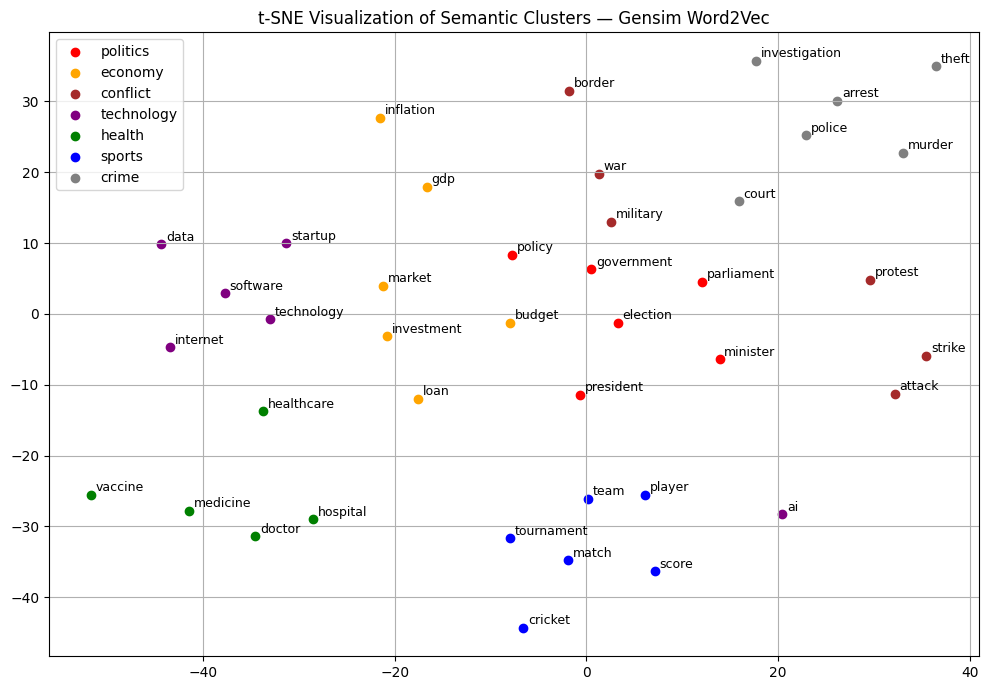

In [ ]:
all_words = []
all_labels = []
vectors = []

for group, words in semantic_categories.items():
    for word in words:
        if word in model:
            all_words.append(word)
            all_labels.append(group)
            vectors.append(model[word])

if len(all_words) < 5:
    print("Too few valid words found in the model vocabulary.")
else:
    vectors = np.array(vectors)
    tsne = TSNE(n_components=2, random_state=42, perplexity=10, init="pca", learning_rate="auto")
    reduced = tsne.fit_transform(vectors)

    plt.figure(figsize=(10, 7))
    for i, (word, group) in enumerate(zip(all_words, all_labels)):
        plt.scatter(reduced[i, 0], reduced[i, 1], c=category_colors[group], label=group if group not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.text(reduced[i, 0] + 0.5, reduced[i, 1] + 0.5, word, fontsize=9)

    plt.title("t-SNE Visualization of Semantic Clusters — Gensim Word2Vec")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def get_top_k_neighbors_gensim(word, model, k=10):

    neighbors = model.most_similar(positive=[word], topn=k)
    return neighbors


neigh_list= ["government", "budget", "vaccine", "strike", "internet"]
for w in neigh_list:
  print(get_top_k_neighbors_gensim(w,model))

[('Government', 0.7132059335708618), ('goverment', 0.7049152851104736), ('governent', 0.6665107011795044), ('governments', 0.6521533727645874), ('govern_ment', 0.6326169371604919), ('governmnent', 0.6278249025344849), ('governement', 0.6268108487129211), ('govenrment', 0.6198932528495789), ('governemnt', 0.6029759049415588), ('govt', 0.5979937314987183)]
[('budgets', 0.7688789367675781), ('budgetary', 0.7214239835739136), ('budget_shortfall', 0.7173871994018555), ('buget', 0.7030661106109619), ('Budget', 0.6575251817703247), ('biennium', 0.6460732221603394), ('departmental_budgets', 0.628609836101532), ('Budgets', 0.6278057098388672), ('budgeted', 0.609143078327179), ('appropriations', 0.602472186088562)]
[('vaccines', 0.876278281211853), ('flu_vaccine', 0.8431119322776794), ('flu_vaccines', 0.8153071999549866), ('influenza_vaccine', 0.8150689005851746), ('H#N#_vaccine', 0.8139630556106567), ('swine_flu_vaccine', 0.7865129709243774), ('H#N#_vaccines', 0.7665912508964539), ('influenza_v

In [ ]:
def get_cosine_similarity_gensim(word1, word2, model):
    if word1 in model and word2 in model:
        return model.similarity(word1, word2)

In [ ]:
for category_name, pairs in {
    "Related": related_pairs,
    "Unrelated": unrelated_pairs,
    "Synonyms": synonym_pairs,
    "Antonyms": antonym_pairs,
}.items():
    print(f"\n== {category_name.upper()} ==")
    for w1, w2 in pairs:
        try:
            score = get_cosine_similarity_gensim(w1, w2, model)
            print(f"{w1:10s} - {w2:10s}: {score:.4f}")
        except KeyError as e:
            print(e)


== RELATED ==
king       - queen     : 0.6511
doctor     - nurse     : 0.6320
apple      - banana    : 0.5318
car        - engine    : 0.4080
sun        - light     : 0.4009
teacher    - student   : 0.6301

== UNRELATED ==
ratio      - king      : 0.0383
river      - computer  : 0.0551
doctor     - tigress   : 0.1332
banana     - gun       : 0.0743
banana     - oil       : 0.1970
shoe       - sky       : 0.0547
chair      - language  : 0.0635
dog        - keyboard  : 0.0961

== SYNONYMS ==
fast       - quick     : 0.5702
big        - large     : 0.5561
happy      - joyful    : 0.4238
smart      - intelligent: 0.6495
cold       - chilly    : 0.6879
angry      - mad       : 0.6057

== ANTONYMS ==
hot        - cold      : 0.4602
happy      - sad       : 0.5355
big        - small     : 0.4959
fast       - slow      : 0.5314
love       - hate      : 0.6004
light      - dark      : 0.4713


In [ ]:
for category_name, pairs in {
    "Related": related_pairs_news,
    "Unrelated": unrelated_pairs_news,
    "Synonyms": synonym_pairs_news,
    "Antonyms": antonym_pairs_news,
}.items():
    print(f"\n== {category_name.upper()} ==")
    for w1, w2 in pairs:
        try:
            score = get_cosine_similarity_gensim(w1, w2, model)
            print(f"{w1:10s} - {w2:10s}: {score:.4f}")
        except KeyError as e:
            print(e)


== RELATED ==
government - policy    : 0.3408
vaccine    - immunity  : 0.2765
inflation  - prices    : 0.5431
protest    - strike    : 0.3417
election   - vote      : 0.6027
budget     - deficit   : 0.5496

== UNRELATED ==
democracy  - banana    : 0.1405
gdp        - guitar    : 0.0295
pandemic   - truck     : 0.0517
minister   - moon      : 0.0153
stock      - tree      : 0.0798
soldier    - piano     : 0.0644
hospital   - keyboard  : 0.0287
court      - shampoo   : 0.0296

== SYNONYMS ==
pandemic   - epidemic  : 0.6384
protest    - demonstration: 0.5737
policy     - regulation: 0.3325
military   - army      : 0.6824
virus      - pathogen  : 0.5771
president  - leader    : 0.4556

== ANTONYMS ==
peace      - war       : 0.3408
inflation  - deflation : 0.6913
liberal    - conservative: 0.7633
public     - private   : 0.5784
growth     - recession : 0.4035
freedom    - censorship: 0.4534


In [ ]:
def metaphor_analogy_mining_gensim(model):
    """
    Test metaphorical relationships and analogy consistency in Gensim embeddings
    Args:
        model: Gensim KeyedVectors or model.wv (must support similarity and vector lookup)
    """

    def get_word_vector(word):
        if word in model:
            return model[word]
        return None

    def cosine_sim(vec1, vec2):
        return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

    def analogy_score(word_a, word_b, word_c, word_d):
        vecs = [get_word_vector(w) for w in [word_a, word_b, word_c, word_d]]
        if any(v is None for v in vecs):
            return None
        vec_a, vec_b, vec_c, vec_d = vecs
        analogy_vec = vec_b - vec_a + vec_c
        return cosine_sim(analogy_vec, vec_d)


    metaphors = {
        "time_is_money": {
            "time_words": ["time", "hour", "minute", "second", "deadline", "schedule"],
            "money_words": ["money", "cost", "expensive", "cheap", "spend", "invest"]
        },
        "argument_is_war": {
            "argument_words": ["argument", "debate", "discuss", "point", "position"],
            "war_words": ["attack", "defend", "strategy", "win", "lose", "battle"]
        },
        "love_is_journey": {
            "love_words": ["love", "relationship", "romance", "partner", "together"],
            "journey_words": ["path", "journey", "road", "destination", "travel"]
        }
    }

    analogy_chains = [
        ("king", "queen", "man", "woman"),
        ("uncle", "aunt", "brother", "sister"),
        ("boy", "girl", "son", "daughter"),
        ("actor", "actress", "hero", "heroine"),
        ("big", "small", "large", "tiny"),
        ("hot", "cold", "warm", "cool")
    ]

    print("=== METAPHOR & ANALOGY MINING ===\n")

    metaphor_scores = {}
    for metaphor_name, word_sets in metaphors.items():
        print(f"Testing metaphor: {metaphor_name.replace('_', ' ').title()}")

        set1_name, set1_words = list(word_sets.items())[0]
        set2_name, set2_words = list(word_sets.items())[1]

        available_set1 = [w for w in set1_words if w in model]
        available_set2 = [w for w in set2_words if w in model]

        if len(available_set1) < 2 or len(available_set2) < 2:
            print(f"  Not enough words available. Skipping.\n")
            continue

        cross_similarities = []
        within_set1_similarities = []
        within_set2_similarities = []

        for w1 in available_set1:
            vec1 = get_word_vector(w1)

            for w2 in available_set2:
                vec2 = get_word_vector(w2)
                if vec1 is not None and vec2 is not None:
                    cross_similarities.append(cosine_sim(vec1, vec2))

            for w2 in available_set1:
                if w1 != w2:
                    vec2 = get_word_vector(w2)
                    if vec2 is not None:
                        within_set1_similarities.append(cosine_sim(vec1, vec2))

        for w1 in available_set2:
            vec1 = get_word_vector(w1)
            for w2 in available_set2:
                if w1 != w2:
                    vec2 = get_word_vector(w2)
                    if vec2 is not None:
                        within_set2_similarities.append(cosine_sim(vec1, vec2))

        avg_cross = np.mean(cross_similarities) if cross_similarities else 0
        avg_within1 = np.mean(within_set1_similarities) if within_set1_similarities else 0
        avg_within2 = np.mean(within_set2_similarities) if within_set2_similarities else 0

        coherence_score = avg_cross / max(avg_within1, avg_within2, 0.001)

        metaphor_scores[metaphor_name] = {
            'coherence_score': coherence_score,
            'cross_similarity': avg_cross,
            'within_similarity_1': avg_within1,
            'within_similarity_2': avg_within2
        }

        print(f"  Cross-domain similarity: {avg_cross:.4f}")
        print(f"  Within-{set1_name} similarity: {avg_within1:.4f}")
        print(f"  Within-{set2_name} similarity: {avg_within2:.4f}")
        print(f"  Metaphor coherence score: {coherence_score:.4f}\n")

    print("Testing Analogy Chains:")
    analogy_scores = []

    for word_a, word_b, word_c, word_d in analogy_chains:
        score = analogy_score(word_a, word_b, word_c, word_d)
        if score is not None:
            analogy_scores.append(score)
            print(f"  {word_a} : {word_b} :: {word_c} : {word_d} = {score:.4f}")
        else:
            print(f"  {word_a} : {word_b} :: {word_c} : {word_d} = N/A (missing words)")

    avg_analogy_score = np.mean(analogy_scores) if analogy_scores else 0
    print(f"\nAverage Analogy Score: {avg_analogy_score:.4f}")

    return {
        'metaphor_scores': metaphor_scores,
        'analogy_scores': analogy_scores,
        'avg_analogy_score': avg_analogy_score
    }

results = metaphor_analogy_mining_gensim(model)

=== METAPHOR & ANALOGY MINING ===

Testing metaphor: Time Is Money
  Cross-domain similarity: 0.0763
  Within-time_words similarity: 0.2528
  Within-money_words similarity: 0.3184
  Metaphor coherence score: 0.2396

Testing metaphor: Argument Is War
  Cross-domain similarity: 0.1576
  Within-argument_words similarity: 0.1716
  Within-war_words similarity: 0.2151
  Metaphor coherence score: 0.7325

Testing metaphor: Love Is Journey
  Cross-domain similarity: 0.0956
  Within-love_words similarity: 0.2684
  Within-journey_words similarity: 0.3312
  Metaphor coherence score: 0.2886

Testing Analogy Chains:
  king : queen :: man : woman = 0.7187
  uncle : aunt :: brother : sister = 0.8226
  boy : girl :: son : daughter = 0.9127
  actor : actress :: hero : heroine = 0.6975
  big : small :: large : tiny = 0.5665
  hot : cold :: warm : cool = 0.3076

Average Analogy Score: 0.6709


<ipython-input-90-888677742>:25: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='average')


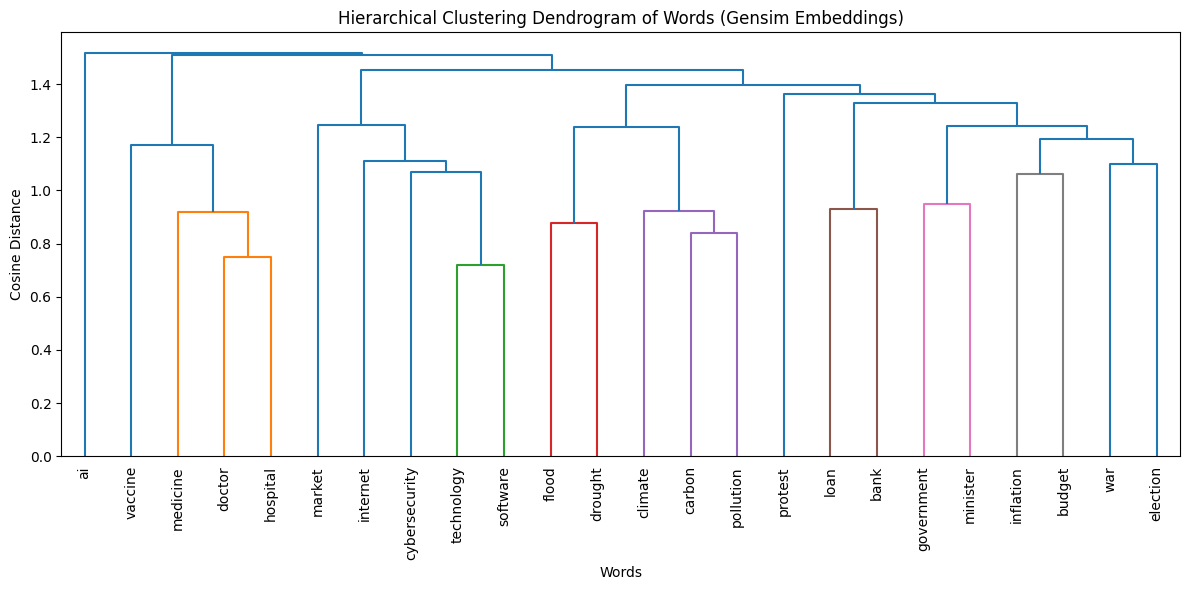

In [ ]:
# words = ["cat", "dog", "lion", "tiger", "elephant", "car", "bus", "truck",
#          "hammer", "screwdriver", "doctor", "nurse", "teacher", "apple", "banana"]
news_words = [
    #conflict/politics
    "war", "protest", "election", "government", "minister",

    #economy
    "market", "inflation", "budget", "loan", "bank",

    #technology
    "technology", "ai", "software", "internet", "cybersecurity",

    #health
     "vaccine", "doctor", "hospital", "medicine",

    #climate/environment
    "climate", "flood", "drought", "carbon", "pollution"
]


vectors = np.array([model[word] for word in news_words])

distance_matrix = cosine_distances(vectors)

linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=news_words, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram of Words (Gensim Embeddings)")
plt.xlabel("Words")
plt.ylabel("Cosine Distance")
plt.tight_layout()
plt.show()